# Introduction

This notebook demonstrates the integration of the CSV file loader into the tslib (Time Series Library) framework. The primary goal is to leverage the capabilities of tslib such as normalizer, windowing, and more on time series data loaded from CSV files.

In [1]:
%load_ext autoreload
%autoreload 2
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import sys
sys.path.append('../../')
from omegaconf import OmegaConf
from dacite import from_dict
from pprint import pprint
from tsbench.tslib.loading.csv_loader import CSVTimeSeriesDataset
from tsbench.tslib.traindataset_generator import TimeSeriesTrainDatasetGeneratorConfig, TimeSeriesTrainDatasetGenerator

/system/apps/userenv/prudniko/xlstm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr>

# The Data

We start with revisiting our previous steps, and checking the correctness of our implementation.

In [2]:
TRAIN_FILE = '../../datafiles/har_with_smartphones/train.csv'
TRAIN_FILE = Path(TRAIN_FILE)

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING


In [4]:
# List of classes, index is the class index
list(train_df['Activity'].unique())

['STANDING',
 'SITTING',
 'LAYING',
 'WALKING',
 'WALKING_DOWNSTAIRS',
 'WALKING_UPSTAIRS']

At first we doublecheck that the data is loaded correctly and we have all timeseries at hand:

In [5]:
raw_ds = CSVTimeSeriesDataset(data_file=TRAIN_FILE, meta_columns=['subject', 'Activity'])

Inherited from `TimeSeriesDataset`, `CSVTimeSeriesDataset` has a handy function `get_meta_data_summary`, which is designed to generate a summary DataFrame containing metadata for a given set of samples within a time series dataset.
The function first checks whether specific indices have been provided. If not, it defaults to using all indices within the dataset. For each index specified, the function retrieves the metadata from the corresponding time series sample. The metadata is extracted by converting the meta_data attribute of each sample to a dictionary.
Finally, the list of dictionaries is converted into a Pandas DataFrame.
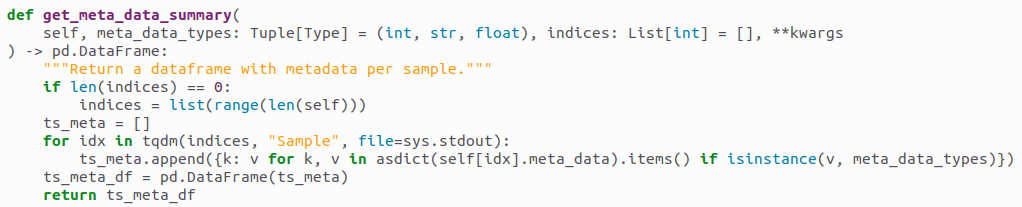

In [6]:
raw_ds.get_meta_data_summary()

Sample: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 414.79it/s]


,key,index,num_timesteps
0,1_LAYING,0,50
1,1_SITTING,1,47
2,1_STANDING,2,53
3,1_WALKING,3,95
4,1_WALKING_DOWNSTAIRS,4,49
...,...,...,...
121,30_SITTING,121,62
122,30_STANDING,122,59
123,30_WALKING,123,65
124,30_WALKING_DOWNSTAIRS,124,62


In [7]:
raw_ds.__getitem__(0), raw_ds.__getitem__(0).key

(<tsbench.tslib.loading.csv_loader.CSVTimeSeries at 0x7faf67467d00>,
 '1_LAYING')

In [8]:
raw_ds[0], raw_ds[0].key

(<tsbench.tslib.loading.csv_loader.CSVTimeSeries at 0x7faf67465240>,
 '1_LAYING')

In [9]:
raw_ds[0].dataframe.head()

,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)","fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2",...,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std()
51,0.432479,-0.553351,-0.432876,-0.043105,-0.068580,0.487505,-0.332249,-0.995811,-0.993967,-0.992241,...,0.375115,-0.991495,0.141102,-0.871221,-0.850645,-0.825061,-0.905123,-0.991665,-0.905123,-0.831696
52,0.399853,-0.550364,-0.427593,0.223038,-0.113048,0.359037,-0.393075,-0.999808,-0.999888,-0.999555,...,-0.314871,-0.999703,-0.558140,-0.986420,-0.982006,-0.978538,-0.987446,-0.996034,-0.987446,-0.978470
53,0.399066,-0.546725,-0.431244,-0.018635,0.293145,0.453923,-0.246980,-0.999957,-0.999976,-0.999908,...,-0.207468,-0.999973,-0.828351,-0.995252,-0.996106,-0.995777,-0.997988,-0.996034,-0.997988,-0.996097
54,0.399555,-0.546477,-0.431646,0.149804,0.240526,0.386719,0.393611,-0.999977,-0.999955,-0.999968,...,-0.073308,-0.999998,-0.873174,-0.996018,-0.998212,-0.997131,-0.999504,-0.995840,-0.999504,-0.998705
55,0.398889,-0.546712,-0.431207,-0.469155,-0.347519,-0.354146,0.308855,-0.999982,-0.999975,-0.999912,...,-0.341771,-0.999992,-0.868779,-0.996306,-0.998018,-0.995563,-0.999058,-0.997326,-0.999058,-0.998274


<hr>

# First Dataset Config

Then we need to create a configuration for tslib. For this we need to mirror the config defined in `tslib/traindataset_generator.py`.

For most of the classes responsible for handling the training such as we specify arguments, to configure the whole process.

The config below is only a first minimal example. Also the time series are not normalized here.

In [10]:
cfg = """ 
pipeline:
  dataset:
    name: csvloader
    kwargs:
      data_file: ../../datafiles/har_with_smartphones/train.csv
      meta_columns: [subject, Activity]
  windowing:
    window_size: 20 # each time series for the model will have length 10
    stride: 5 # each time series will be shifted by 5
  # TODO add normalization of the features
  # store normalizer values in a file and load them in the normalizer
  target_generator:
    name: csv_classification
    kwargs:
      class_column: Activity
      class_labels: ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

split: 
  name: random_split
  kwargs:
    lengths: [0.8, 0.2] # train, val
"""
cfg = OmegaConf.create(cfg)

cfg = from_dict(data_class=TimeSeriesTrainDatasetGeneratorConfig, data=OmegaConf.to_container(cfg))

In [11]:
print(cfg)

TimeSeriesTrainDatasetGeneratorConfig(pipeline=ComposedTimeSeriesDatasetConfig(dataset=NameAndKwargs(name='csvloader', kwargs={'data_file': '../../datafiles/har_with_smartphones/train.csv', 'meta_columns': ['subject', 'Activity']}), windowing=TimeSeriesWindowDatasetConfig(window_size=20, stride=5, initial_offset=0, end_offset=0, future_steps=0, past_steps=0), partition_filter=NameAndKwargs(name='no_filter', kwargs={}), feature_selector=FeatureSelectorConfig(select_features=[], drop_features=[]), normalizer=NormalizerConfig(normalizer_values={}, normalize_features=set(), drop_zero_variance_features=True, eps=1e-08, normalizer_file=None), transforms=[], target_generator=NameAndKwargs(name='csv_classification', kwargs={'class_column': 'Activity', 'class_labels': ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']}), cache_processed_dataset=False), split=NameAndKwargs(name='random_split', kwargs={'lengths': [0.8, 0.2]}), metric_train=[], metric_val=[])


<hr>
With this config file, we can again discover almost the full structure of classes involved.

In [12]:
def recursive_print(cls, char="=", depth=0, max_depth=4):
    if depth > max_depth:
        return
    if isinstance(cls,dict) and len(cls)>0:
        print("|  " * depth, "{")
        for key, value in cls.items():
            print("|  " * depth, key, ": ", value)
        print("|  " * depth, "}")
    else: 
        for key, value in vars(cls).items():
            print("|  " * depth +"=" * (100-len("|  " * depth)))
            print("|  " * depth + key)
            print("|  " * depth + str(type(value)))
            try:
                recursive_print(value, char="=", depth=depth + 1, max_depth=max_depth)
            except:
                print("|  "*depth, value)


In [13]:
print(type(cfg))
recursive_print(cfg)

<class 'tsbench.tslib.traindataset_generator.TimeSeriesTrainDatasetGeneratorConfig'>
pipeline
<class 'tsbench.tslib.composed_dataset.ComposedTimeSeriesDatasetConfig'>
|  =================================================================================================
|  dataset
|  <class 'tsbench.ml_utils.config.NameAndKwargs'>
|  |  ==============================================================================================
|  |  name
|  |  <class 'str'>
|  |   csvloader
|  |  ==============================================================================================
|  |  kwargs
|  |  <class 'dict'>
|  |  |   {
|  |  |   data_file :  ../../datafiles/har_with_smartphones/train.csv
|  |  |   meta_columns :  ['subject', 'Activity']
|  |  |   }
|  =================================================================================================
|  windowing
|  <class 'tsbench.tslib.postprocessing.window_dataset.TimeSeriesWindowDatasetConfig'>
|  |  ===================================

<hr>

# Dataset Generator

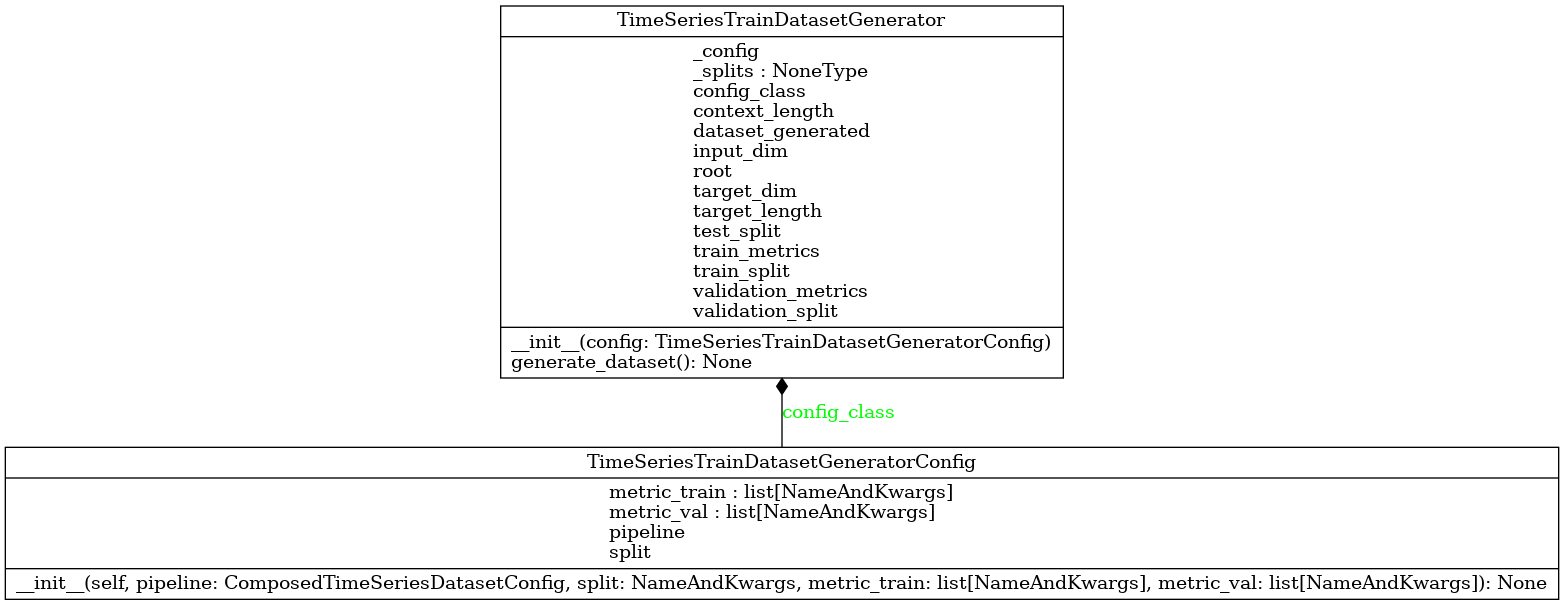
### Configuration Class (TimeSeriesTrainDatasetGeneratorConfig)

This is a data class (annotated by `@dataclass`) that holds the configuration parameters for generating a time series training dataset. Key attributes include:

- `pipeline`: An instance of `ComposedTimeSeriesDatasetConfig` that specifies the composition and transformations for the dataset.
- `split`: An instance of `NameAndKwargs` specifying the method for splitting the dataset.
- `metric_train`: A list of metrics for training evaluation.
- `metric_val`: A list of metrics for validation evaluation.

### Dataset Generator Class (TimeSeriesTrainDatasetGenerator)

This class implements the `DatasetGeneratorInterface`. It takes an instance of `TimeSeriesTrainDatasetGeneratorConfig` as a parameter during initialization. The `generate_dataset` method creates the time series dataset based on the provided configuration. It uses a subset generator and a `ComposedTimeSeriesDataset`.

The class provides properties to access various aspects of the generated dataset:

- `dataset_generated`: Checks if the dataset has been generated.
- `train_split`, `validation_split`, `test_split`: Accessors for the training, validation, and test splits of the dataset.
- `train_metrics`, `validation_metrics`: Accessors for the training and validation metrics.
- `target_dim`, `input_dim`, `context_length`, `target_length`, `root`: Properties providing information about the dataset dimensions and structure.

### Purpose

This code helps make time series training datasets for machine learning in a structured and reusable way. It separates the setup (configuration) from creating the dataset, making it easier to handle and customize datasets for different machine learning models.


In [14]:
ds_gen = TimeSeriesTrainDatasetGenerator(cfg)

In [15]:
exclude_for_now = []
for key, value in vars(ds_gen).items():
    if key in exclude_for_now: continue
    print("="*100)    
    print(key)
    display(value)

_config


TimeSeriesTrainDatasetGeneratorConfig(pipeline=ComposedTimeSeriesDatasetConfig(dataset=NameAndKwargs(name='csvloader', kwargs={'data_file': '../../datafiles/har_with_smartphones/train.csv', 'meta_columns': ['subject', 'Activity']}), windowing=TimeSeriesWindowDatasetConfig(window_size=20, stride=5, initial_offset=0, end_offset=0, future_steps=0, past_steps=0), partition_filter=NameAndKwargs(name='no_filter', kwargs={}), feature_selector=FeatureSelectorConfig(select_features=[], drop_features=[]), normalizer=NormalizerConfig(normalizer_values={}, normalize_features=set(), drop_zero_variance_features=True, eps=1e-08, normalizer_file=None), transforms=[], target_generator=NameAndKwargs(name='csv_classification', kwargs={'class_column': 'Activity', 'class_labels': ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']}), cache_processed_dataset=False), split=NameAndKwargs(name='random_split', kwargs={'lengths': [0.8, 0.2]}), metric_train=[], metric_val=[])

_splits


None

The '`TimeSeriesTrainDatasetGenerator` has attribute `_splits` which is empty before calling `generate_dataset()` and filled after. 

In [16]:
ds_gen.generate_dataset()

Generating window index: 100%|██████████████████████████████████████████████| 126/126 [00:00<00:00, 8040.81it/s]
Total number of dropped timesteps due to windowing: 272


In [17]:
exclude_for_now = ['_config']
for key, value in vars(ds_gen).items():
    if key in exclude_for_now: continue
    print("="*100)    
    print(key)
    display(value)

_splits


`_splits` is a list of train (position 0) and validation (position 1) subsets. Test subset is optional, and could be at position 2. 
To add test set just specify the portion of data dedicated to it in the config, e.g.:<br> 
`split:`<br> 
  `  name: random_split`<br> 
  `  kwargs:`<br> 
    `    lengths: [0.8, 0.15, 0.05] # train, val, test`<br> 

<hr>

# Train dataset

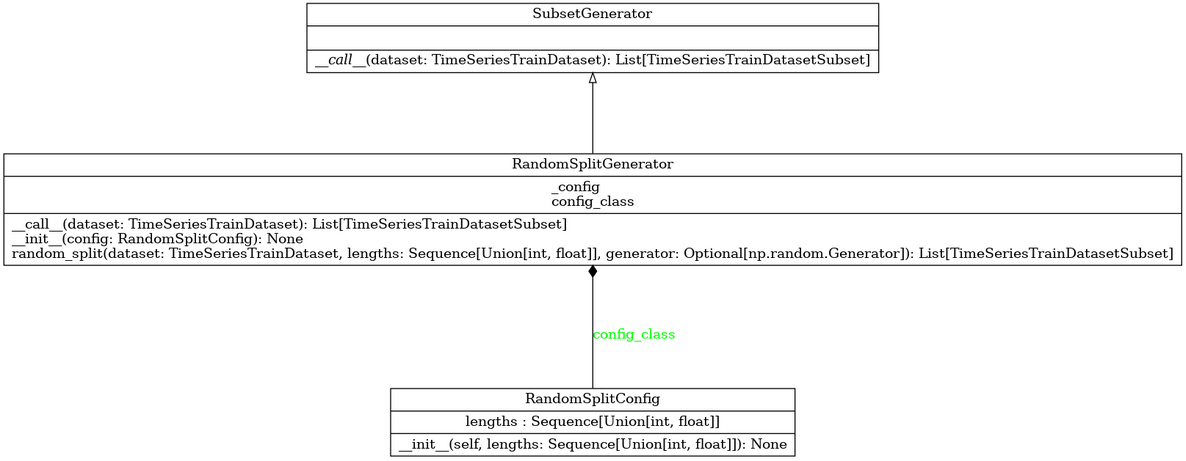
<hr>

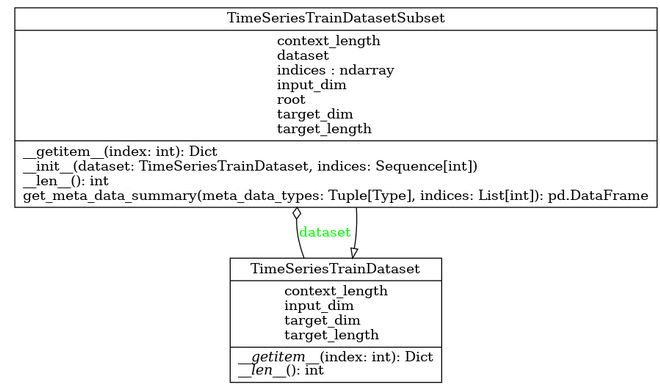
`TimeSeriesTrainDataset` is the base class for time series train datasets. This class defines the interface for training frameworks, i.e. provides the dimensions of the input and outputs.
`TimeSeriesTrainDatasetSubset` is used for train, validation and test splits of the main dataset.

`TimeSeriesTrainDatasetSubset` is the instance which will go to the dataloaders, and the to the training loop. 

*When you implement your own task specific CSV-loading-datasets make sure to return the same datatypes as we did in notebook 2. This is crucial compatability requirement.*

<hr>

Below we explore some basic properties of the `TimeSeriesTrainDatasetSubset`

In [18]:
train_ds = ds_gen.train_split
val_ds = ds_gen.validation_split
train_ds

In [19]:
train_ds.get_meta_data_summary()

,ComposedTimeSeriesDataset_index,CSVTimeSeriesDataset_index,key,index,num_timesteps
0,513,67,19_SITTING_wi[|35:35|35:55|55:55|],513,20
1,798,98,26_STANDING_wi[|50:50|50:70|70:70|],798,20
2,883,108,28_LAYING_wi[|30:30|30:50|50:50|],883,20
3,2,0,1_LAYING_wi[|10:10|10:30|30:30|],2,20
4,595,76,21_WALKING_DOWNSTAIRS_wi[|5:5|5:25|25:25|],595,20
...,...,...,...,...,...
826,82,10,3_WALKING_DOWNSTAIRS_wi[|0:0|0:20|20:20|],82,20
827,369,51,15_WALKING_wi[|0:0|0:20|20:20|],369,20
828,562,73,21_SITTING_wi[|15:15|15:35|35:35|],562,20
829,650,84,23_LAYING_wi[|0:0|0:20|20:20|],650,20


`train_ds.get_meta_data_summary()` gives us information about all time series included in the dataset. <br>Notice that keys are extended, and every sample has length of 20, because we have applied windowing.

For instance, initial measurement for subject 21 in walking state, which consisted of 45 samples, is now splitted into 7 timeseries. `window=20, stride=5`. Those time series are located in both, train and validation sets.

*Q: Maybe for some later experiments you would like to try splitting timeseries not randomly but by subject for example.*

In [20]:
# the original timeseries, the one we developed in notebook 2
original = train_ds.dataset.dataset.dataset.dataset.get_meta_data_summary()
original.head(6)

Sample: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 405.79it/s]


,CSVTimeSeriesDataset_index,key,index,num_timesteps
0,0,1_LAYING,0,50
1,1,1_SITTING,1,47
2,2,1_STANDING,2,53
3,3,1_WALKING,3,95
4,4,1_WALKING_DOWNSTAIRS,4,49
5,5,1_WALKING_UPSTAIRS,5,53


In [21]:
original[original['key'].str.contains('21_WALKING')]

,CSVTimeSeriesDataset_index,key,index,num_timesteps
75,75,21_WALKING,75,52
76,76,21_WALKING_DOWNSTAIRS,76,45
77,77,21_WALKING_UPSTAIRS,77,47


In [22]:
display(train_ds.get_meta_data_summary()[train_ds.get_meta_data_summary()['key'].str.contains('21_WALKING_wi')])
display(val_ds.get_meta_data_summary()[val_ds.get_meta_data_summary()['key'].str.contains('21_WALKING_wi')])

,ComposedTimeSeriesDataset_index,CSVTimeSeriesDataset_index,key,index,num_timesteps
388,590,75,21_WALKING_wi[|15:15|15:35|35:35|],590,20
393,589,75,21_WALKING_wi[|10:10|10:30|30:30|],589,20
462,587,75,21_WALKING_wi[|0:0|0:20|20:20|],587,20
795,588,75,21_WALKING_wi[|5:5|5:25|25:25|],588,20


,ComposedTimeSeriesDataset_index,CSVTimeSeriesDataset_index,key,index,num_timesteps
20,592,75,21_WALKING_wi[|25:25|25:45|45:45|],592,20
115,593,75,21_WALKING_wi[|30:30|30:50|50:50|],593,20
116,591,75,21_WALKING_wi[|20:20|20:40|40:40|],591,20


In [23]:
train_ds[0] #getitem

{'x': tensor([[-0.4581, -0.1030, -0.3039,  ..., -0.9861, -0.9724, -0.9806],
         [-0.4550, -0.1039, -0.3058,  ..., -0.9945, -0.9772, -0.9829],
         [ 0.1062, -0.3395, -0.5171,  ..., -0.9321, -0.8889, -0.9153],
         ...,
         [-0.6517, -0.0929, -0.1359,  ..., -0.9110, -0.7530, -0.5462],
         [-0.7156, -0.0548, -0.1137,  ..., -0.9908, -0.9478, -0.9370],
         [-0.6989, -0.0670, -0.1167,  ..., -0.9908, -0.9776, -0.9826]]),
 'y': tensor(1)}

In [24]:
train_ds[0]['x'].shape # 20 steps and 561 features

torch.Size([20, 561])

In [25]:
len(train_ds), len(ds_gen.validation_split), type(ds_gen.validation_split)

(831,
 207,
 tsbench.tslib.postprocessing.dataset_subset.TimeSeriesTrainDatasetSubset)

In [26]:
train_ds.input_dim, train_ds.context_length # 561 features is input dimension

(561, 20)

In [27]:
train_ds.target_dim, train_ds.target_length 
# 6 classes 'STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'

(6, 1)

# Target Generator

We have noticed that samples from `TimeSeriesTrainDatasetSubset` are represented by dictionary with keys 'x' and 'y', where naturally 'y' = target.

To generate those targets we use yet another set of classes `TargetGenerator`.

As for now we have 2 main implementations of target generators.
`~/tsbench/tsbench/tslib/target/__init__.py`
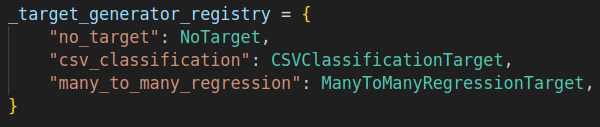

`TargetGenerator` receives the `TimeSeries` as the main argument. Every `TargetGenerator` must have the following methodsd:
- `get_input_shape`
- `get_inputs`
- `get_target_shape`
- `get_targets`
If eventually you need to implement your own target generator, be sure to check those methods for correct output types.


`CSVClassificationTarget` is used when you deal with classification problems. To use this type of target generator one should provide the column name containing labels as well as list of labels themself. 
`CSVClassificationTargetConfig` inherits from `ClassificationTarget` and `BaseClassificationTarget`. Explore those classes, and write your version of `CSVClassificationTargetConfig` or extend it if the functionality is not enough.


`ManyToManyRegressionTarget` is a simple target generator which receives list of column names for features, and a list of column names for targets. Getting methods then simply return filtered information from dataframes.

# Another config
Now with normalisation

In [28]:
# this is only a minimal config and the time series are not normalized

cfg = """ 
pipeline:
  dataset:
    name: csvloader
    kwargs:
      data_file: ../../datafiles/har_with_smartphones/train.csv
      meta_columns: [subject, Activity]
  windowing:
    window_size: 20 # each time series for the model will have length 10
    stride: 5 # each time series will be shifted by 5
  normalizer:
    normalizer_file: ../../datafiles/har_with_smartphones/normalizer.json
  target_generator:
    name: csv_classification
    kwargs:
      class_column: Activity
      class_labels: ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

split: 
  name: random_split
  kwargs:
    lengths: [0.8, 0.2] # train, val
"""
cfg = OmegaConf.create(cfg)

cfg = from_dict(data_class=TimeSeriesTrainDatasetGeneratorConfig, data=OmegaConf.to_container(cfg))
print(type(cfg))
recursive_print(cfg)

<class 'tsbench.tslib.traindataset_generator.TimeSeriesTrainDatasetGeneratorConfig'>
pipeline
<class 'tsbench.tslib.composed_dataset.ComposedTimeSeriesDatasetConfig'>
|  =================================================================================================
|  dataset
|  <class 'tsbench.ml_utils.config.NameAndKwargs'>
|  |  ==============================================================================================
|  |  name
|  |  <class 'str'>
|  |   csvloader
|  |  ==============================================================================================
|  |  kwargs
|  |  <class 'dict'>
|  |  |   {
|  |  |   data_file :  ../../datafiles/har_with_smartphones/train.csv
|  |  |   meta_columns :  ['subject', 'Activity']
|  |  |   }
|  =================================================================================================
|  windowing
|  <class 'tsbench.tslib.postprocessing.window_dataset.TimeSeriesWindowDatasetConfig'>
|  |  ===================================

Now we see that normalizer section of printed config is not empty.
One of important parts of it is the normaliser file.

In [29]:
import json

with open('../../datafiles/har_with_smartphones/normalizer.json') as f:
    d = json.load(f)
print(list(d.keys()))
print(len(d['mean'].keys()), list(d['mean'].keys()))

['mean', 'std']
562 ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravi

This file is what we have collected in the 1st notebook, and is a collection of `mean` and `std` for every feature.

In [30]:
ds_gen2 = TimeSeriesTrainDatasetGenerator(cfg)
ds_gen2.generate_dataset()

Generating window index: 100%|███████████████████████████████████████████████| 126/126 [00:00<00:00, 775.34it/s]
Total number of dropped timesteps due to windowing: 272


In [31]:
train_ds2 = ds_gen2.train_split
val_ds2 = ds_gen2.validation_split

We can first notice that for the same sample in `train_ds` and `train_ds2` the `mean` and `std` across features is different.

In [32]:
train_ds2[0]['x'].std(dim=1)

tensor([0.7877, 0.7337, 0.8154, 0.7617, 0.7614, 0.8006, 0.8981, 0.9508, 0.8908,
        0.7566, 0.7189, 0.7249, 0.6916, 0.7748, 0.6982, 0.6685, 0.6051, 0.6087,
        0.6786, 0.6866])

In [33]:
train_ds[0]['x'].std(dim=1)

tensor([0.5267, 0.5381, 0.5520, 0.5479, 0.5563, 0.5426, 0.5246, 0.5243, 0.5299,
        0.5362, 0.5345, 0.5372, 0.5243, 0.5258, 0.5326, 0.5361, 0.5326, 0.5487,
        0.5648, 0.5496])

Normalization was performede correctly if all timeseries accumulated have $\mu=0$ and $\sigma=1$.
We will check this as well.

In [34]:
from tqdm import tqdm
import torch 

all_series = None
for ds in [train_ds2,val_ds2]:
    for idx in tqdm(range(ds.__len__())):
        ts = ds[idx]['x']
        if all_series is None:
            all_series = ts
        else:
            all_series = torch.cat((all_series, ts), dim=0)


100%|█████████████████████████████████████████████████████████████████████████| 207/207 [00:17<00:00, 11.54it/s]


In [35]:
all_series.std(dim=0)

tensor([1.0209, 1.0105, 1.0213, 0.9869, 0.9805, 0.9969, 0.9830, 0.9559, 0.9701,
        0.9823, 0.9566, 0.9709, 0.9802, 0.9574, 0.9699, 0.9854, 0.9711, 0.9801,
        0.9597, 0.9690, 0.9801, 0.9494, 0.9584, 0.9809, 0.9229, 0.9577, 0.9806,
        0.9252, 0.9590, 0.9833, 0.9192, 0.9561, 0.9754, 0.9291, 0.9520, 0.9605,
        0.9468, 0.9448, 0.9698, 0.9725, 0.9455, 0.9724, 0.9749, 0.9466, 0.9719,
        0.9779, 0.9503, 0.9654, 0.9594, 0.9566, 0.9709, 0.9784, 0.9936, 0.9975,
        0.9932, 0.9799, 0.9800, 0.9725, 1.0036, 0.9982, 0.9915, 0.9794, 0.9859,
        0.9860, 0.9749, 0.9848, 0.9948, 1.0189, 1.0004, 1.0083, 0.9796, 0.9846,
        0.9816, 1.0046, 1.0125, 0.9932, 0.9821, 0.9687, 0.9801, 1.0059, 1.0000,
        0.9952, 0.9822, 0.9771, 0.9872, 0.9916, 0.9507, 0.9639, 0.9601, 0.9570,
        0.9690, 0.9540, 0.9454, 0.9613, 0.9671, 0.9682, 0.9786, 0.9472, 0.9660,
        0.9787, 0.9352, 0.9591, 0.9787, 0.9205, 0.9576, 0.9756, 0.9257, 0.9576,
        0.9791, 0.9193, 0.9547, 0.9671, 

In [36]:
torch.allclose(all_series.std(dim=0),torch.tensor(1.),atol=0.11)

True

In [37]:
all_series.mean(dim=0)

tensor([ 0.0281, -0.0271, -0.0364,  0.0018,  0.0020, -0.0027,  0.0087, -0.0511,
        -0.0494, -0.0366, -0.0514, -0.0497, -0.0387, -0.0502, -0.0490, -0.0315,
        -0.0394, -0.0387, -0.0368, -0.0411, -0.0406, -0.0391, -0.0403, -0.0409,
        -0.0397, -0.0428, -0.0427, -0.0418, -0.0416, -0.0388, -0.0414, -0.0427,
        -0.0416, -0.0426, -0.0407, -0.0417, -0.0404, -0.0355, -0.0350, -0.0338,
        -0.0319, -0.0313, -0.0308, -0.0230, -0.0198, -0.0184, -0.0474, -0.0390,
        -0.0415, -0.0514, -0.0499, -0.0397, -0.0492, -0.0511, -0.0504, -0.0498,
        -0.0494, -0.0502, -0.0169, -0.0044, -0.0093, -0.0511, -0.0493, -0.0478,
        -0.0517, -0.0484, -0.0405,  0.0037, -0.0079, -0.0031, -0.0508, -0.0502,
        -0.0496,  0.0306,  0.0228,  0.0215, -0.0292, -0.0354, -0.0322, -0.0205,
        -0.0064, -0.0104, -0.0516, -0.0519, -0.0493, -0.0450, -0.0513, -0.0431,
        -0.0431, -0.0502, -0.0444, -0.0438, -0.0501, -0.0486, -0.0358, -0.0393,
        -0.0396, -0.0393, -0.0414, -0.04

In [38]:
torch.allclose(all_series.mean(dim=0),torch.tensor(0.),atol=0.1)

True